In [1]:
from commonfunctions import *
import numpy as np
import cv2 as cv
import mediapipe as mp
from time import sleep


In [2]:
# get threshold value
def calcThreshold(hist, accHist, iFrom, iTo):
    iFrom, iTo = int(iFrom), int(iTo)
    numOfPixels = accHist[iTo] - (accHist[iFrom - 1] if iFrom > 0 else 0)
    mean = np.sum(
        hist[iFrom:iTo+1] * np.arange(iFrom, iTo+1)
    ) / numOfPixels
    return round(mean)

# np.arange([1 , 2] < 3)


def avgThreshold(hist, accHist, Tinit):
    mean1 = calcThreshold(hist, accHist, 0, Tinit - 1)
    mean2 = calcThreshold(hist, accHist, Tinit, hist.shape[0] - 1)
    newThreshold = round((mean1 + mean2) / 2)
    return newThreshold if Tinit == newThreshold else avgThreshold(hist, accHist, newThreshold)


def getGlobalThreshold(img):
    img2 = np.copy(img)
    hist = np.histogram(img2, bins=np.arange(256))[0]
    accHist = np.cumsum(hist)
    Tinit = calcThreshold(hist, accHist, 0, hist.shape[0] - 1)
    return avgThreshold(hist, accHist, Tinit)# get threshold


In [3]:
def get_image_with_skin_color(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = (B - Y) * 0.564 + 128
    Cr = (R - Y) * 0.713 + 128
    outImg = (Cb >= 77) * (Cb <= 127) * (Cr >= 133) * (Cr <= 180)
    return outImg


In [4]:
def enhance_image(img):
    se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]).astype('uint8')
    enhanced_image = np.array(img).astype('uint8')
    enhanced_image = cv.dilate(
        enhanced_image, se, iterations=15
    )
    enhanced_image = cv.erode(
        enhanced_image, se, iterations=15
    )
    return enhanced_image




In [5]:

def detectHand(binaryImg, mainImg):
    contours = find_contours(binaryImg,  fully_connected='high')
    for contour in contours:
        Ymin = int(np.min(contour[:, 1]))
        Ymax = int(np.max(contour[:, 1]))
        Xmin = int(np.min(contour[:, 0]))
        Xmax = int(np.max(contour[:, 0]))
        if Xmax - Xmin >= 50 and Ymax - Ymin >= 50:
            detectedImage = np.array(mainImg[Xmin:Xmax, Ymin:Ymax])
            mp_hands = mp.solutions.hands
            hand = mp_hands.Hands()
            result = hand.process(detectedImage)
            if result.multi_hand_landmarks:
                # th = getGlobalThreshold(detectedImage)
                # show_images([detectedImage > th])
                return np.array(binaryImg[Xmin:Xmax, Ymin:Ymax]), ((Xmin+Xmax)//2, (Ymin+Ymax)//2)
    return None, (0, 0)


In [6]:
def captureImage(cap):
    success, img = cap.read()
    img = cv.flip(img, 1)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # print(imgRGB)
    if cv.waitKey(1) & 0xff == ord('q'):
        cv.destroyAllWindows()
        cap.release()
        exit(0)
    return imgRGB


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


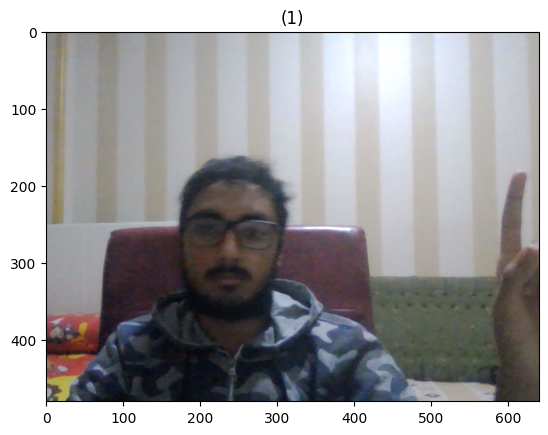

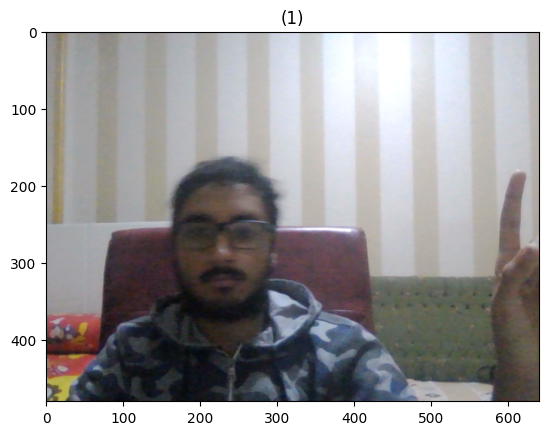

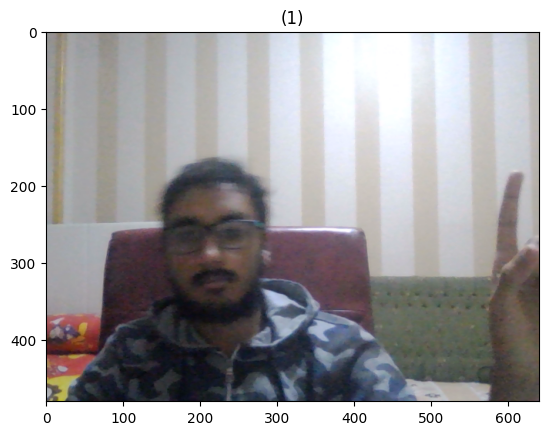

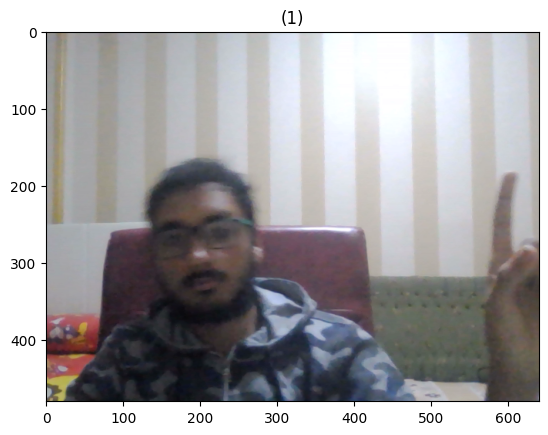

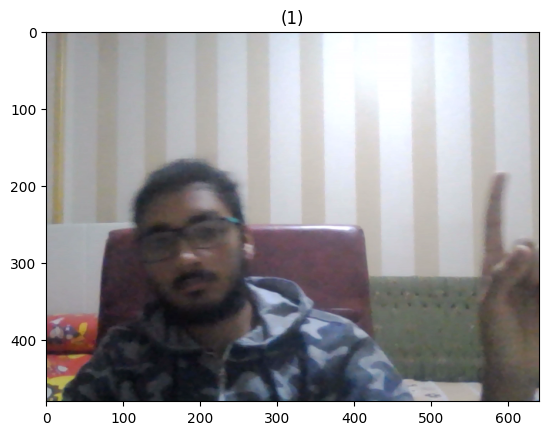

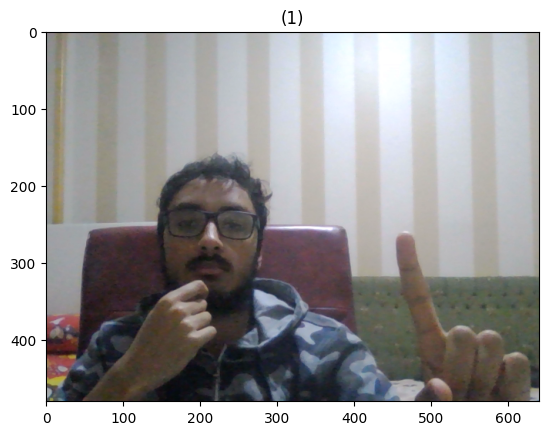

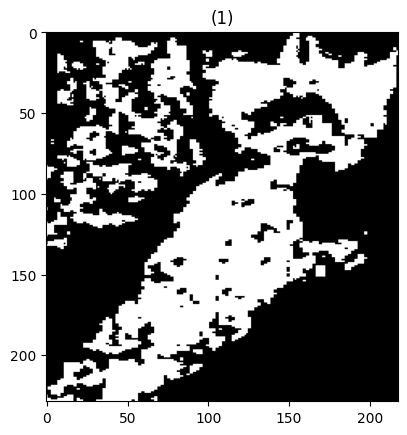

(364, 164)


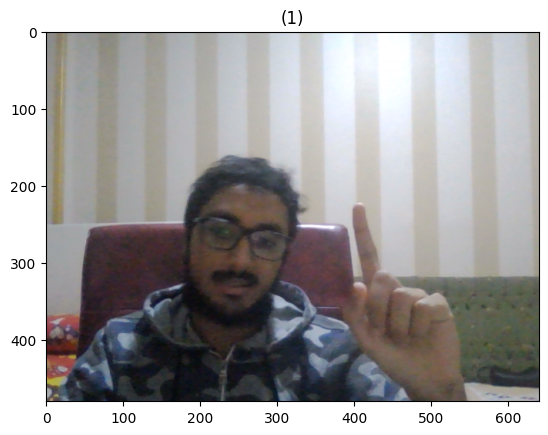

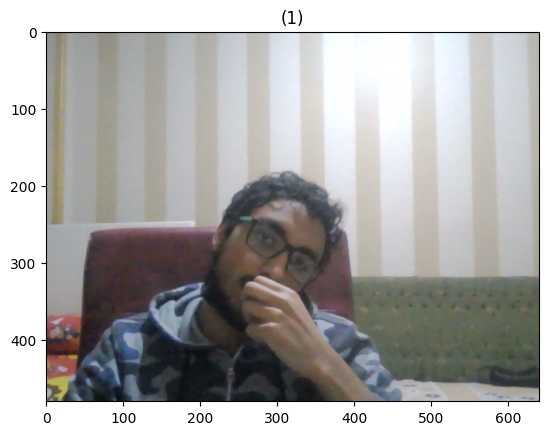

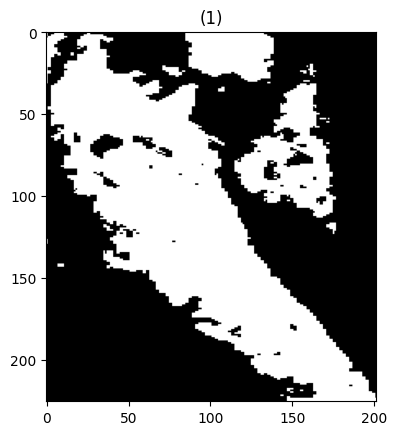

(366, 324)


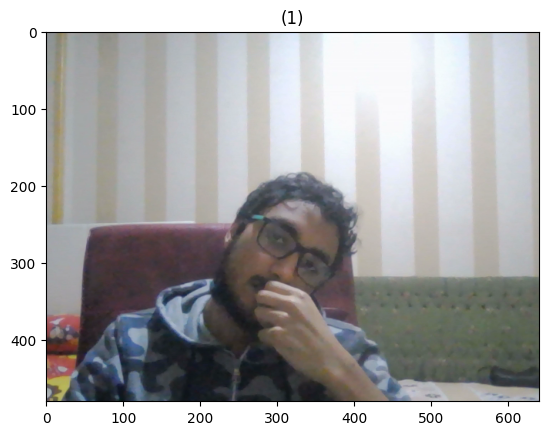

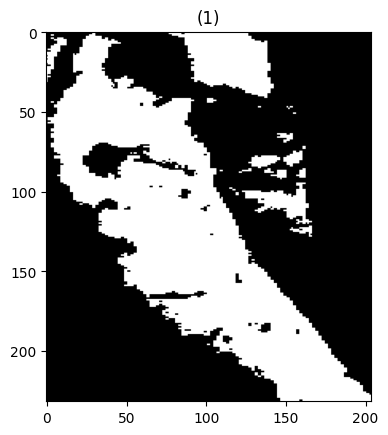

(363, 339)


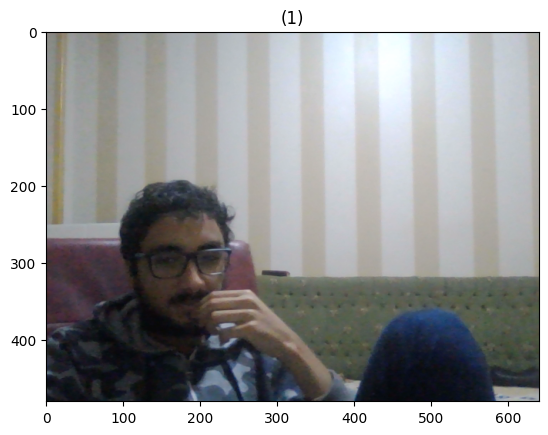

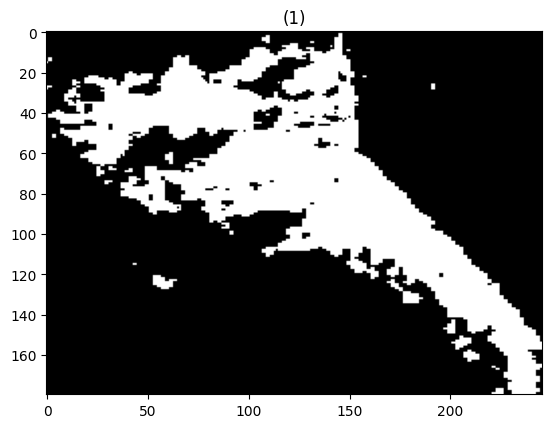

(378, 244)


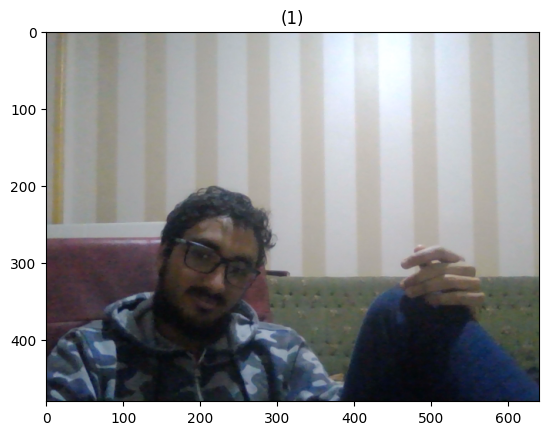

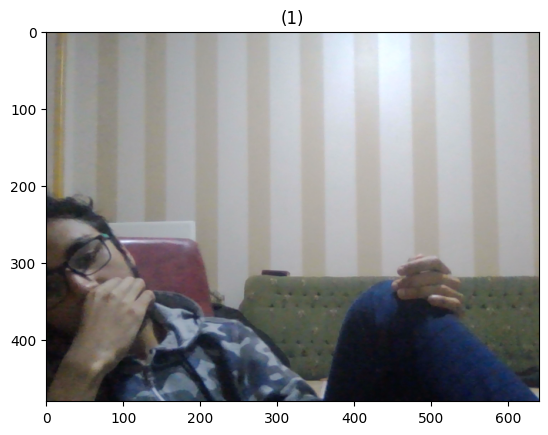

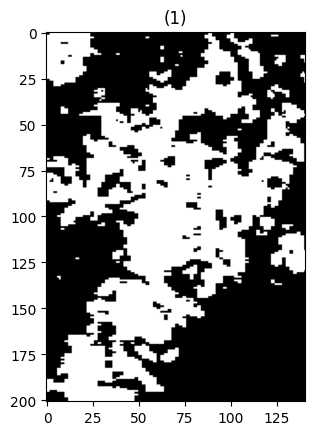

(378, 70)


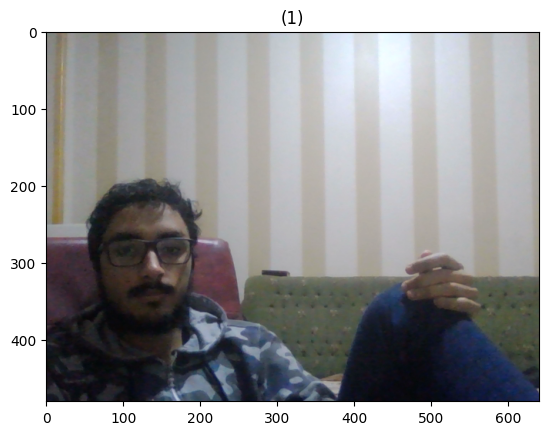

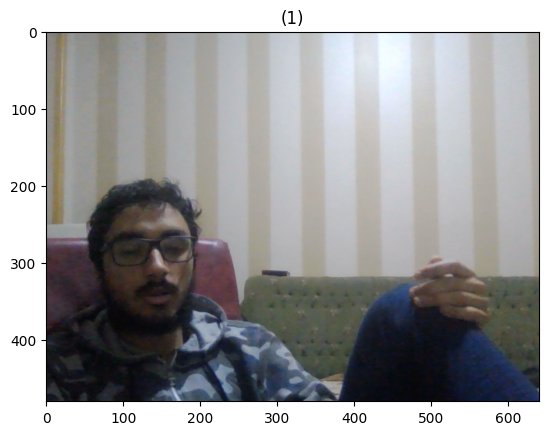

In [7]:
def main():
    #
    cap = cv.VideoCapture(-1)
    while True:
        img = captureImage(cap)
        sleep(10)
        binary_image = get_image_with_skin_color(img)
        hand_image, center = detectHand(binary_image, img)
        show_images([img])
        if hand_image is not None:
            show_images([hand_image])
            print(center)


if __name__ == "__main__":
    main()
